# Part 3: Serving
In this part we will user MLRun's **serving runtime** to deploy our trained models from the previous stage a `Voting Ensemble` using **max vote** logic.  
We will also use MLRun's **Feature store** to receive the latest tag of the online **Feature Vector** we defined in the preveious stage.

We will:
- Define a model class to load our models, run preprocessing and predict on the data
- Define Voting Ensemble function on top of our models
- Test the serving function locally using our `mock server`
- Deploy the function to the cluster and test it live


## Environment Setup

Since our work is done in a this project scope, we will first want to define the project itself for all our MLRun work in this notebook.

In [1]:
import mlrun
project, _ = mlrun.set_environment(project='fraud-demo', user_project=True)

## Define Model Class
- Load models
- Predict from the FS Online service via the `source` key

In [2]:
# nuclio: start-code

In [3]:
from cloudpickle import load
import numpy as np
import mlrun
import os

class ClassifierModel(mlrun.serving.V2ModelServer):
    
    def load(self):
        """load and initialize the model and/or other elements"""
        model_file, extra_data = self.get_model('.pkl')
        self.model = load(open(model_file, 'rb'))
        
        # Setup FS Online service
        feature_vector_name = os.getenv('FEATURE_VECTOR_NAME', 'transactions-fraud')
        feature_vector_tag = os.getenv('FEATURE_VECTOR_TAG', 'v1')
        self.feature_service = mlrun.feature_store.get_online_feature_service(f'{feature_vector_name}:{feature_vector_tag}')
        
        # Get feature vector statistics for imputing
        self.feature_stats = self.feature_service.vector.get_stats_table()
        
        # Default category
        self.default_category = 0
        
    def preprocess(self, body: dict, op) -> list:
        """Turn an entity identifier (source) to a Feature Vector"""
        # Get patient feature vector 
        # from the patient_id given in the request
        vectors = self.feature_service.get([{'source': source} for source in body['inputs']])
        
        # Impute inf's in the data to the feature's mean value
        # using the collected statistics from the Feature store
        feature_vectors = []
        for fv in vectors:
            new_vec = []
            for f, v in fv.items():
                if type(v) == float:
                    if np.isinf(v) or np.isnan(v):
                        new_vec.append(self.feature_stats.loc[f, 'mean'])
                    else:
                        new_vec.append(v)
                elif v == None:
                    new_vec.append(self.default_category)
                else:
                    new_vec.append(v)
            feature_vectors.append(new_vec)
            
        # Set the final feature vector as our inputs
        # to pass to the predict function
        body['inputs'] = feature_vectors
        return body

    def predict(self, body: dict) -> list:
        """Generate model predictions from sample"""
        feats = np.asarray(body['inputs'])
        result: np.ndarray = self.model.predict(feats)
        return result.tolist()

In [4]:
# nuclio: end-code

## Define Serving Function
- Gather ClassifierModel code from this notebook
- Define `VotingEnsemble` - Max-Vote based ensemble
- Add downloaded models to the ensemble

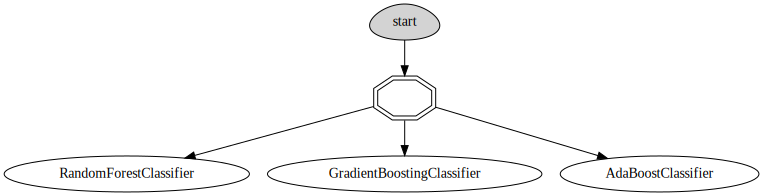

In [5]:
from mlrun import auto_mount

# Create the serving function from our code above
fn = mlrun.code_to_function('transaction-fraud', kind='serving', image="mlrun/mlrun")

# Apply a mount so we can load the model files directly from the v3io fs
fn.apply(auto_mount())

# Set the Voting Ensemble as our router
fn.set_topology('router', 'mlrun.serving.VotingEnsemble', name='Transactionfraud')

# Add the three previously trained models to the ensemble
db = mlrun.get_run_db()
sklearn_models = db.list_artifacts(project=project, best_iteration=False, labels={'framework': 'sklearn'})
models = {model['algorithm']: os.path.join(model['target_path'], model['model_file']) for model in sklearn_models}

for model_name, model_path in models.items():
    fn.add_model(model_name, class_name="ClassifierModel", model_path=model_path)
    
# Set the feature vector and tag for the model to pickup
# setting them as environment variables allows us to easily
# update the function with new feature vector and it's being
# tracked by MLRun as a function parameter.
feature_vector_name = 'transactions-fraud'
feature_vector_tag = 'v1'
fn.set_envs({'FEATURE_VECTOR_NAME': feature_vector_name,
             'FEATURE_VECTOR_TAG': feature_vector_tag})
    
# Plot the ensemble configuration
fn.spec.graph.plot()

## Test the server locally

In [6]:
# Create a mock server from the serving function
server = fn.to_mock_server()

> 2021-06-20 08:23:50,893 [info] model RandomForestClassifier was loaded
> 2021-06-20 08:23:50,952 [info] model GradientBoostingClassifier was loaded
> 2021-06-20 08:23:51,001 [info] model AdaBoostClassifier was loaded
> 2021-06-20 08:23:51,002 [info] Loaded ['RandomForestClassifier', 'GradientBoostingClassifier', 'AdaBoostClassifier']


### View a sample of the online features

In [7]:
import mlrun.feature_store as fs

# Create the online feature service
svc = fs.get_online_feature_service('transactions-fraud:v1')

# Get sample feature vector
sample_id = 'C76780537'
sample_fv = svc.get([{'source': sample_id}])
sample_fv

[{'amount_sum_2h': 0.0,
  'amount_sum_12h': 128.69,
  'amount_sum_24h': 196.29,
  'amount_max_2h': -inf,
  'amount_max_12h': 106.24,
  'amount_max_24h': 106.24,
  'amount_count_2h': 0.0,
  'amount_avg_12h': 42.89666666666667,
  'amount': 3.28}]

In [8]:
import json

# Send a sample ID for predcition
server.test(path='/v2/models/infer',
            body=json.dumps({'inputs': [sample_id]}))

{'id': '4c38e61352884579a0e38914e59b8bc1',
 'model_name': [0],
 'outputs': [0],
 'model_version': 'v1'}

### Test the function on the kubernetes cluster

#### Deploy

In [9]:
addr = fn.deploy()

> 2021-06-20 08:23:51,126 [info] Starting remote function deploy
2021-06-20 08:23:51  (info) Deploying function
2021-06-20 08:23:51  (info) Building
2021-06-20 08:23:51  (info) Staging files and preparing base images
2021-06-20 08:23:51  (info) Building processor image
2021-06-20 08:23:53  (info) Build complete
2021-06-20 08:24:01  (info) Function deploy complete
> 2021-06-20 08:24:02,316 [info] function deployed, address=default-tenant.app.dev6.lab.iguazeng.com:31573


In [10]:
fn.invoke(path='/v2/models/infer',
          body=json.dumps({'inputs': [sample_id]}))

{'id': '7abdc722-c7b6-4c8b-9edc-138c1afd25f6',
 'model_name': [0],
 'outputs': [0],
 'model_version': 'v1'}